In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

## Red Neuronal LSTM con dataset de KAGGLE para series de tiempo
#### https://www.kaggle.com/datasets/ixhele/bitcoin-time-series
####  Contexto
#### Los datos representan series de tiempo históricas diarias para una moneda digital (BTC)
Rango de fecha de datos: 2018-05-11 al 2021-01-30

In [2]:
# Paso 1: Cargar el dataset
df = pd.read_csv('bitcoin_usd.csv', index_col='Unnamed: 0', parse_dates=True)
df.index.name = 'fecha'  # Renombrar el índice para que sea 'fecha'
df.reset_index(inplace=True)  # Convertir el índice en una columna

In [3]:
# Mostrar las primeras filas para entender la estructura del DataFrame
print(df.head())

       fecha  open_USD  high_USD   low_USD  close_USD  volume
0 2021-01-30  34246.28  34933.00  32825.00   34218.54   43072
1 2021-01-29  33368.18  38531.90  31915.40   34252.20  231827
2 2021-01-28  30362.19  33783.98  29842.10   33364.86   92621
3 2021-01-27  32464.01  32557.29  29241.72   30366.15   95911
4 2021-01-26  32254.19  32921.88  30837.37   32467.77   84972


In [4]:
# Convertir la columna 'fecha' en tipo datetime y ordenar el dataframe
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha')

In [5]:
# Paso 2: Preparar los datos
data = df[['close_USD']].copy()

In [6]:
# Mostrar las primeras filas para entender la estructura del DataFrame
print(data.head())

     close_USD
999    9365.00
998    9187.56
997    9310.00
996    9002.20
995    8400.00


In [7]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [8]:

# Crear un dataset de secuencias
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
SEQ_LENGTH = 60  # Número de días para cada secuencia
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [10]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# Paso 3: Definir y compilar el modelo
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\deyvi.caicedo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Paso 3: Construcción del modelo
#model = Sequential()
#model.add(LSTM (16, activation='relu', input_shape=(SEQ_LENGTH, 1))) 
#model.add (Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Paso 4: Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.0054 - val_loss: 2.4936e-04
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 6.0116e-04 - val_loss: 1.4396e-04
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2175e-04 - val_loss: 8.2246e-05
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 3.7716e-04 - val_loss: 1.0306e-04
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 3.4173e-04 - val_loss: 1.0108e-04
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.6486e-04 - val_loss: 1.0754e-04
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.8478e-04 - val_loss: 1.5685e-04
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.1517e-04 - val_loss: 6.9135e-05
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 2.5033e-04 - val_loss: 6.5875e-05
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 2.5934e-04 - val_loss: 1.5615e-04


In [14]:
# Paso 5: Hacer predicciones
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


In [15]:
# Desnormalizar las predicciones y los datos de prueba
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 1)), y_test], axis=1))[:, 1]
y_pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), 1)), y_pred], axis=1))[:, 1]

In [16]:
# Calcular métricas de evaluación
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

In [17]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 6140159.812475307
Root Mean Squared Error (RMSE): 2477.934585996028
Mean Absolute Error (MAE): 1702.3982154696553


In [18]:
# Paso 6: Graficar resultados
plt.figure(figsize=(18, 12))

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

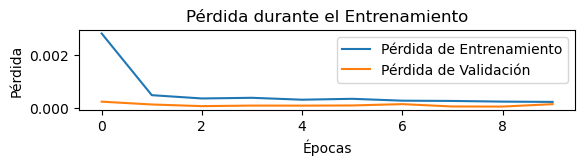

In [19]:
# Gráfico de la pérdida durante el entrenamiento
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

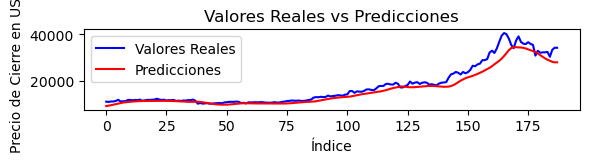

In [20]:
# Gráfico de las predicciones vs los valores reales
plt.subplot(4, 1, 2)
plt.plot(range(len(y_test_inv)), y_test_inv, label='Valores Reales', color='blue')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicciones', color='red')
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre en USD')
plt.legend()

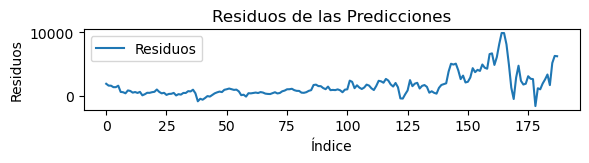

In [21]:
# Gráfico de los residuos
residuals = y_test_inv - y_pred_inv
plt.subplot(4, 1, 3)
plt.plot(residuals, label='Residuos')
plt.title('Residuos de las Predicciones')
plt.xlabel('Índice')
plt.ylabel('Residuos')
plt.legend()

In [43]:
# Gráfico de zoom: ventana t-1 (puedes ajustar el rango según tus necesidades)
start_index = 0  # Cambiar para ver una ventana diferente
end_index = 80  # Cambiar para ajustar la ventana de zoom

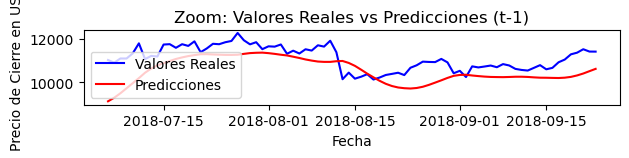

In [44]:
plt.subplot(4, 1, 4)
plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_test_inv[start_index:end_index], label='Valores Reales', color='blue')
plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_pred_inv[start_index:end_index], label='Predicciones', color='red')
plt.title('Zoom: Valores Reales vs Predicciones (t-1)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre en USD')
plt.legend()
plt.tight_layout()
plt.show()

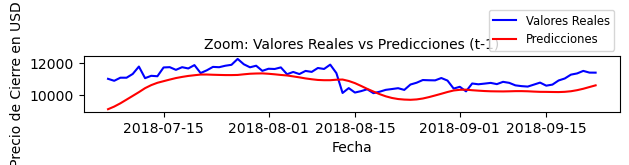

In [45]:
import matplotlib.pyplot as plt

# Configurar la gráfica
plt.subplot(4, 1, 4)

# Plotear los datos
plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_test_inv[start_index:end_index], label='Valores Reales', color='blue')
plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_pred_inv[start_index:end_index], label='Predicciones', color='red')

# Añadir título
plt.title('Zoom: Valores Reales vs Predicciones (t-1)', fontsize=10)

# Añadir etiquetas
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre en USD')

# Añadir leyenda con tamaño y ubicación ajustados
#plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0, 1.05))
plt.legend(loc='lower right', fontsize='small', bbox_to_anchor=(1,1))

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()
